# Article Page Views API Example
This example illustrates how to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). This example shows how to request monthly counts of page views for one specific article. The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.

## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 14, 2023



In [1]:
import pandas as pd
import numpy as np

In this step, I'm connecting my Google Drive to Google Colab. By doing this, I can access files and folders stored in my Google Drive directly within my Colab notebook. Once the connection is established, I set a specific folder named "DATA512_HW1" as my working directory. After that, I load a CSV file called "thank_the_academy.AUG.2023.csv" into a pandas DataFrame, which I've named "MOVIE_URL." Lastly, I'm displaying the first few rows of this DataFrame using the head() method to take a quick look at the data.

In [2]:
from google.colab import drive
import sys

drive.mount('/content/drive')

FOLDERNAME = "DATA512_HW1"
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/

MOVIE_SHEET = 'thank_the_academy.AUG.2023.csv'
MOVIE_URL = pd.read_csv(MOVIE_SHEET)

MOVIE_URL.head()

Mounted at /content/drive
/content/drive/My Drive/DATA512_HW1


,name,url
0,Everything Everywhere All at Once,https://en.wikipedia.org/wiki/Everything_Every...
1,All Quiet on the Western Front (2022 film),https://en.wikipedia.org/wiki/All_Quiet_on_the...
2,The Whale (2022 film),https://en.wikipedia.org/wiki/The_Whale_(2022_...
3,Top Gun: Maverick,https://en.wikipedia.org/wiki/Top_Gun:_Maverick
4,Black Panther: Wakanda Forever,https://en.wikipedia.org/wiki/Black_Panther:_W...


First, I'm importing libraries like Matplotlib, Pandas, and others that will help me with data visualization and manipulation.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import json, time, urllib.parse
import requests
import seaborn as sns
import re

Next, I've set some constants. These include URLs and parameters for making requests to the Wikimedia API, as well as some values to control the rate of these requests. I've also included a user-agent header with my email address, as recommended by Wikimedia, for potential communication.

I have a list of English Wikipedia article titles that I'll use as examples for my requests.

Additionally, I've created a template that I'll use to structure my API requests for pageview data. It specifies how the request URL should be constructed and includes placeholders for various parameters.

In [6]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<avivam@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # 1st July 2015
    "end":         "2023093000"    # 30th Sept 2023
}

request_pageviews_per_article allows me to make requests to the Wikimedia API to get pageview data for a specific Wikipedia article and access type. It takes parameters such as the article title, access type, and others.

In [7]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded

    if access_type:
        request_template['access'] = access_type

    if not request_template['access']:
        raise Exception("Must supply an access_type to make a pageviews request.")

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




In the subsequent code, I'm actually using this function. I make a request to get pageview data for the article titled "Northern flicker" with the access type "mobile-web." I then display the retrieved data for each month in a readable JSON format.

In [8]:
print("Getting pageview data for: ",ARTICLE_TITLES[1])
views = request_pageviews_per_article(ARTICLE_TITLES[1], 'mobile-web')

Getting pageview data for:  Northern flicker


After that, I start working with a Pandas DataFrame named movies_df. I loop through a list of movie names obtained from a CSV file (MOVIE_URL) and request pageview data for each movie and different access types ('desktop', 'mobile-app', 'mobile-web'). If the data is usable (i.e., it contains 'items'), I create a DataFrame for that movie's pageview data and add it to the movies_df.

In [9]:
print("Have %d months of pageview data"%(len(views['items'])))
for month in views['items']:
    print(json.dumps(month,indent=4))

Have 99 months of pageview data
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015070100",
    "access": "mobile-web",
    "agent": "user",
    "views": 4791
}
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015080100",
    "access": "mobile-web",
    "agent": "user",
    "views": 4188
}
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015090100",
    "access": "mobile-web",
    "agent": "user",
    "views": 5542
}
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015100100",
    "access": "mobile-web",
    "agent": "user",
    "views": 5707
}
{
    "project": "en.wikipedia",
    "article": "Northern_flicker",
    "granularity": "monthly",
    "timestamp": "2015110100",
    "access": "mobile-web",
    "agent": "user"

Finally, I group the data in movies_df by article and access type and calculate the sum of views for each group.

In [10]:
movies_df = pd.DataFrame()

for movie in MOVIE_URL['name']:
  for accesstype in ['desktop', 'mobile-app', 'mobile-web']:
    views = request_pageviews_per_article(movie, accesstype)

    if 'items' in views:
      mv_df = pd.DataFrame(views['items'])
      movies_df = pd.concat([movies_df, mv_df])

    else:
      print("Non-usable views for article {} and accesstype {}\n {}".format(movie, accesstype, views))

Non-usable views for article Victor/Victoria and accesstype desktop
 {'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found#route', 'title': 'Not found.', 'method': 'get', 'uri': '/wikimedia.org/v1/metrics/pageviews/per-article/en.wikipedia.org/desktop/user/Victor/Victoria/monthly/2015070100/2023093000'}
Non-usable views for article Victor/Victoria and accesstype mobile-app
 {'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found#route', 'title': 'Not found.', 'method': 'get', 'uri': '/wikimedia.org/v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-app/user/Victor/Victoria/monthly/2015070100/2023093000'}
Non-usable views for article Victor/Victoria and accesstype mobile-web
 {'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found#route', 'title': 'Not found.', 'method': 'get', 'uri': '/wikimedia.org/v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-web/user/Victor/Victoria/monthly/2015070100/2023093000'}


In [11]:
movies_df.groupby(['article', 'access'])['views'].agg('sum')

article                  access    
12_Years_a_Slave_(film)  desktop       3991260
                         mobile-app     224073
                         mobile-web    6027265
1917_(2019_film)         desktop       5735418
                         mobile-app     546000
                                        ...   
Zootopia                 mobile-app     459149
                         mobile-web    9390125
Zorba_the_Greek_(film)   desktop        590259
                         mobile-app      39976
                         mobile-web     719511
Name: views, Length: 4074, dtype: int64

**1. Monthly mobile access** - The API separates mobile access types into two separate requests, and I have summed these to make one count for all mobile pageviews. The mobile access data is stored in a file called:
academy_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json


In [12]:
file1_df = movies_df[movies_df['access'] != 'desktop'].groupby(['article', 'timestamp', 'project', 'granularity', 'agent'], as_index=False)['views'].agg('sum')

movies = list(set(file1_df['article']))
cols_needed = [f for f in file1_df.columns if f != 'article']
movies_dict = {}

for m in movies:
  movies_dict[m.replace("_", " ")] = list(file1_df[file1_df['article'] == m][cols_needed].T.to_dict().values())

In [13]:
with open(f"academy_monthly_mobile_201507-202309.json", "w") as file:
    file.write(json.dumps(movies_dict, indent=4))


**2. Monthly desktop access** - Monthly desktop page traffic is based on one single request. I've stored the desktop access data in a file called: academy_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json



In [14]:
file2_df = movies_df[movies_df['access'] == 'desktop'].groupby(['article', 'timestamp', 'project', 'granularity', 'agent', 'access'], as_index=False)['views'].agg('sum')

cols_needed = [f for f in file2_df.columns if f != 'article']
movies2_dict = {}

for m in movies:
  movies2_dict[m.replace("_", " ")] = list(file2_df[file2_df['article'] == m][cols_needed].T.to_dict().values())

In [15]:
with open(f"academy_monthly_desktop_201507-202309.json", "w") as file:
    file.write(json.dumps(movies2_dict, indent=4))

**3. Monthly cumulative** - The monthly cumulative data is the sum of all mobile, and all desktop traffic per article. This is stored in a file called: academy_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json



In [16]:
file3_df = movies_df.groupby(['article', 'timestamp', 'project', 'granularity', 'agent'], as_index=False)['views'].agg('sum')

cols_needed = [f for f in file3_df.columns if f != 'article']
movies3_dict = {}

for m in movies:
  movies3_dict[m.replace("_", " ")] = list(file3_df[file3_df['article'] == m][cols_needed].T.to_dict().values())

In [17]:
with open(f"academy_monthly_cumulative_201507-202309.json", "w") as file:
    file.write(json.dumps(movies3_dict, indent=4))

I performed this step by defining the START_DATE_YM and END_DATE_YM variables. These variables represent the start and end dates for my data analysis, and I removed the day and time components from the template to create them.

In [18]:
START_DATE_YM = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['start'][:-4]
END_DATE_YM = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['end'][:-4]

In this step, I performed the task of creating a function called load_data. This function reads data from a JSON file and structures it into a Pandas DataFrame, making it easier for further analysis.

In [19]:
def load_data(filename):
    with open(filename, "r") as file:
        data = json.load(file)

    views = []

    for movie, values in data.items():
        for month_data in values:
            views.append({
                'project': month_data['project'],
                'article': movie,
                'granularity': month_data['granularity'],
                'timestamp': month_data['timestamp'],
                'agent': month_data['agent'],
                'views': month_data['views']
            })

    return pd.DataFrame(views)

To work with different types of pageview data, I loaded data into separate DataFrames named views_mobile, views_desktop, and views_cumulative. I did this by calling the load_data function for each respective JSON file.

In [20]:
views_mobile = load_data(f"academy_monthly_mobile_{START_DATE_YM}-{END_DATE_YM}.json")
views_desktop = load_data(f"academy_monthly_desktop_{START_DATE_YM}-{END_DATE_YM}.json")
views_cumulative = load_data(f"academy_monthly_cumulative_{START_DATE_YM}-{END_DATE_YM}.json")

In [21]:
views_desktop.shape, views_mobile.shape, views_cumulative.shape

((128860, 6), (128860, 6), (128860, 6))

I calculated the average monthly page requests for both desktop and mobile access types. Additionally, I identified the articles with the highest and lowest average monthly page requests for each access type and printed these results. I also created line plots to visualize the monthly page views for the most and least popular movies by grouping the data by timestamp, article, and access type and displayed trends over time.

Articles with Highest and Lowest Average Monthly Page Requests:
Max Desktop Article: Joker (2019 film), Avg Monthly Page Requests (Desktop): 216853.25396825396
Min Desktop Article: Project Hope (film), Avg Monthly Page Requests (Desktop): 36.61616161616162
Max Mobile Article: The Whale (2022 film), Avg Monthly Page Requests (Mobile): 525412.8666666667
Min Mobile Article: Project Hope (film), Avg Monthly Page Requests (Mobile): 9.11111111111111


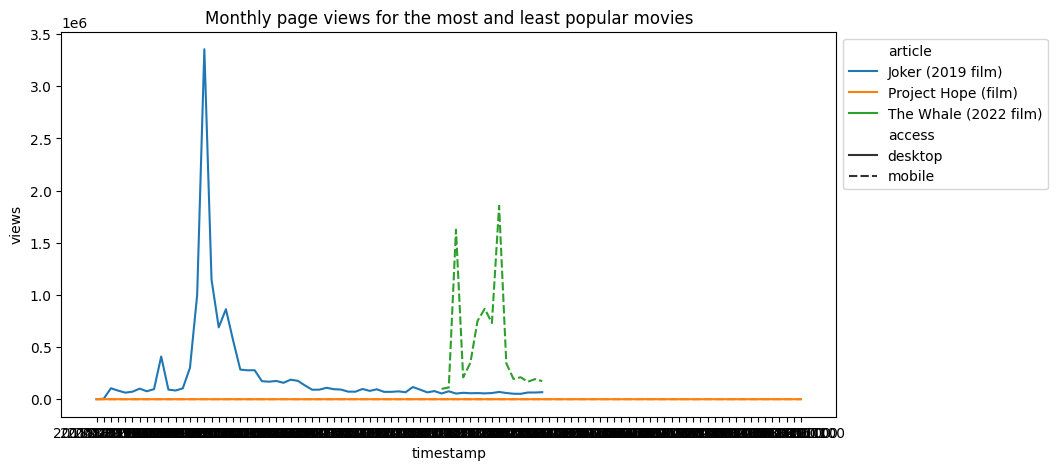

In [22]:
desktop_agg = views_desktop.groupby('article')["views"].mean()
mobile_agg = views_mobile.groupby('article')["views"].mean()
max_desktop = desktop_agg.idxmax()
min_desktop = desktop_agg.idxmin()
max_mobile = mobile_agg.idxmax()
min_mobile = mobile_agg.idxmin()

print("Articles with Highest and Lowest Average Monthly Page Requests:")
print(f"Max Desktop Article: {max_desktop}, Avg Monthly Page Requests (Desktop): {desktop_agg[max_desktop]}")
print(f"Min Desktop Article: {min_desktop}, Avg Monthly Page Requests (Desktop): {desktop_agg[min_desktop]}")
print(f"Max Mobile Article: {max_mobile}, Avg Monthly Page Requests (Mobile): {mobile_agg[max_mobile]}")
print(f"Min Mobile Article: {min_mobile}, Avg Monthly Page Requests (Mobile): {mobile_agg[min_mobile]}")

min_max_desktop = views_desktop[views_desktop['article'].isin([max_desktop, min_desktop])]
min_max_desktop = min_max_desktop.assign(access='desktop')
min_max_mobile = views_mobile[views_mobile['article'].isin([max_mobile, min_mobile])]
min_max_mobile = min_max_mobile.assign(access='mobile')
min_max_df = pd.concat([min_max_desktop, min_max_mobile])

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="timestamp", y="views", hue="article", style="access", data=min_max_df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.title("Monthly page views for the most and least popular movies")
plt.show()


I identified and printed the top 10 movies with the highest peak page views for both desktop and mobile access types.

Here, I generated line plots to visualize the monthly page views for the top 10 movies with the highest peak page views.

Top 10 Movies with Highest Peak Page Views for Desktop Access:
Article: Joker (2019 film), Peak Page Views (Desktop): 3355060
Article: Parasite (2019 film), Peak Page Views (Desktop): 2813357
Article: Black Panther (film), Peak Page Views (Desktop): 2659906
Article: The Revenant (2015 film), Peak Page Views (Desktop): 2165430
Article: Avatar: The Way of Water, Peak Page Views (Desktop): 1890048
Article: Spectre (2015 film), Peak Page Views (Desktop): 1812832
Article: Dune (2021 film), Peak Page Views (Desktop): 1694498
Article: 1917 (2019 film), Peak Page Views (Desktop): 1567798
Article: Tenet (film), Peak Page Views (Desktop): 1565634
Article: Blade Runner 2049, Peak Page Views (Desktop): 1517482

Top 10 Movies with Highest Peak Page Views for Mobile Access:
Article: Avatar: The Way of Water, Peak Page Views (Mobile): 8106378
Article: Joker (2019 film), Peak Page Views (Mobile): 8047344
Article: Black Panther (film), Peak Page Views (Mobile): 5503665
Article: Parasite (2019 film), Pe

Text(0.5, 1.0, 'Top 10 Movie Articles by Peak Page Views and Access Type')

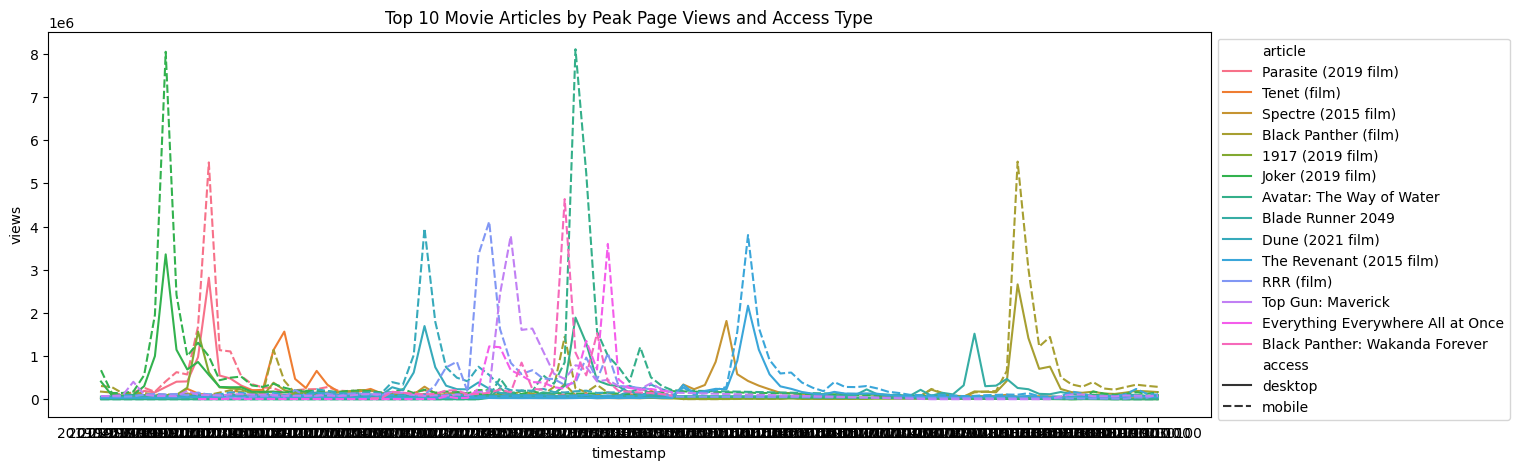

In [25]:
top_10_movie_desktop = views_desktop.groupby("article")["views"].agg('max').sort_values(ascending=False).head(10)
top_10_movie_mobile = views_mobile.groupby("article")["views"].agg('max').sort_values(ascending=False).head(10)

top_10_desktop = views_desktop[views_desktop['article'].isin(top_10_movie_desktop.index)]
top_10_desktop = top_10_desktop.assign(access='desktop')

top_10_mobile = views_mobile[views_mobile['article'].isin(top_10_movie_mobile.index)]
top_10_mobile = top_10_mobile.assign(access='mobile')

top_10_df = pd.concat([top_10_desktop, top_10_mobile])

print("Top 10 Movies with Highest Peak Page Views for Desktop Access:")
for article in top_10_movie_desktop.index:
    max_views = top_10_movie_desktop[article]
    print(f"Article: {article}, Peak Page Views (Desktop): {max_views}")

print("\nTop 10 Movies with Highest Peak Page Views for Mobile Access:")
for article in top_10_movie_mobile.index:
    max_views = top_10_movie_mobile[article]
    print(f"Article: {article}, Peak Page Views (Mobile): {max_views}")


plt.figure(figsize=(15, 5))
ax = sns.lineplot(x="timestamp", y="views", hue="article", style="access", data=top_10_df, legend='full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Top 10 Movie Articles by Peak Page Views and Access Type")

I finally identified and printed articles with the fewest months of available data for both desktop and mobile access types, and then I created line plots to visualize the monthly page views for articles with the fewest months of data.

Articles with the Fewest Months of Data for Desktop Access:
Article: The Boy, the Mole, the Fox and the Horse (film), Months: 10
Article: The Elephant Whisperers, Months: 10
Article: Women Talking (film), Months: 11
Article: Eskimo (1933 film), Months: 12
Article: The Critic (1963 film), Months: 15
Article: The Whale (2022 film), Months: 15
Article: The Queen of Basketball, Months: 20
Article: The Windshield Wiper, Months: 20
Article: Guillermo del Toro's Pinocchio, Months: 21
Article: Navalny (film), Months: 21

Articles with the Fewest Months of Data for Mobile Access:
Article: The Boy, the Mole, the Fox and the Horse (film), Months: 10
Article: The Elephant Whisperers, Months: 10
Article: Women Talking (film), Months: 11
Article: Eskimo (1933 film), Months: 12
Article: The Critic (1963 film), Months: 15
Article: The Whale (2022 film), Months: 15
Article: The Queen of Basketball, Months: 20
Article: The Windshield Wiper, Months: 20
Article: Guillermo del Toro's Pinocchio, Months: 21


<ipython-input-27-c22ad002070f>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for article, months in desktop_fewest_months.iteritems():
<ipython-input-27-c22ad002070f>:20: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for article, months in mobile_fewest_months.iteritems():


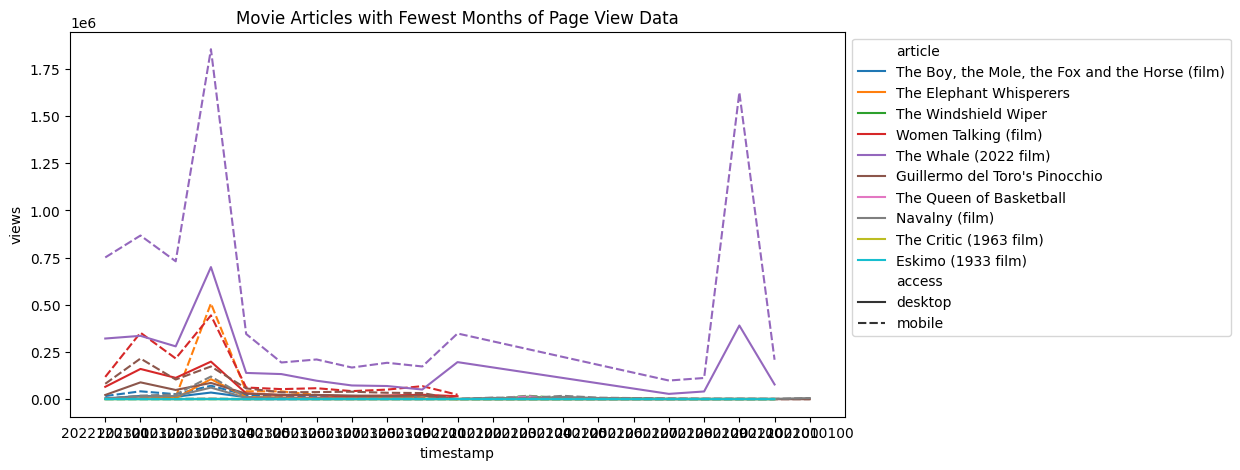

In [27]:
desktop_fewest_movies = views_desktop.groupby("article")["views"].agg('count').sort_values(ascending=True).head(10)
mobile_fewest_movies = views_mobile.groupby("article")["views"].agg('count').sort_values(ascending=True).head(10)

fewest_desktop = views_desktop[views_desktop['article'].isin(desktop_fewest_movies.index)]
fewest_desktop = fewest_desktop.assign(access='desktop')

fewest_mobile = views_mobile[views_mobile['article'].isin(mobile_fewest_movies.index)]
fewest_mobile = fewest_mobile.assign(access='mobile')

fewest_df = pd.concat([fewest_desktop, fewest_mobile])

desktop_fewest_months = fewest_desktop.groupby('article')['timestamp'].nunique().sort_values().head(10)
mobile_fewest_months = fewest_mobile.groupby('article')['timestamp'].nunique().sort_values().head(10)

print("Articles with the Fewest Months of Data for Desktop Access:")
for article, months in desktop_fewest_months.iteritems():
    print(f"Article: {article}, Months: {months}")

print("\nArticles with the Fewest Months of Data for Mobile Access:")
for article, months in mobile_fewest_months.iteritems():
    print(f"Article: {article}, Months: {months}")

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="timestamp", y="views", hue="article", style="access", data=fewest_df, legend='full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Movie Articles with Fewest Months of Page View Data")

plt.show()